In [194]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from gensim.summarization import summarize
from wordcloud import WordCloud # Import the wordcloud library
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from spacy.lang.en import English
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import mglearn

In [195]:
data=pd.read_csv("C:\\Users\\Aiswarya\\Desktop\\comcastcomplaints\\comcast_consumeraffairs_complaints.csv",encoding="latin")
data = data[['rating','author','text']]
data = data[pd.notnull(data['text'])]
data.head(10)

,rating,author,text
0,1,"Alantae of Chesterfeild, MI",I used to love Comcast. Until all these consta...
1,1,"Vera of Philadelphia, PA",I'm so over Comcast! The worst internet provid...
2,1,"Sarah of Rancho Cordova, CA",If I could give them a negative star or no sta...
3,1,"Dennis of Manchester, NH",I've had the worst experiences so far since in...
4,1,"Ryan of Bellevue, WA",Check your contract when you sign up for Comca...
5,1,"Terri of Mobile, AL",Thank God. I am changing to Dish. They gave me...
6,1,"Kellie of Salt Lake City, UT",I Have been a long time customer and only have...
7,2,"Kathleen of New Haven, CT",There is a malfunction on the DVR manager whic...
8,1,"Shira of Bloomfield, NJ",Charges overwhelming. Comcast service rep was ...
9,1,"Kristy of Alpharetta, GA","I have had cable, DISH, and U-verse, etc. in t..."


In [3]:
fcc_df=pd.read_csv("C:\\Users\\Aiswarya\\Desktop\\comcastcomplaints\\comcast_fcc_complaints_2015.csv")
fcc_df.head()

,Ticket #,Customer Complaint,Date,Time,Received Via,City,State,Zip code,Status,Filing on Behalf of Someone,Description
0,250635,Comcast Cable Internet Speeds,4/22/2015,3:53:50 PM,Internet,Abingdon,Maryland,21009,Closed,No,I have been contacting Comcast Internet Techni...
1,223441,Payment disappear - service got disconnected,4/8/2015,10:22:56 AM,Internet,Acworth,Georgia,30102,Closed,No,Back in January 2015 I made 2 payments: One fo...
2,242732,Speed and Service,4/18/2015,9:55:47 AM,Internet,Acworth,Georgia,30101,Closed,Yes,Our home is located at in Acworth Georgia 3010...
3,277946,Comcast Imposed a New Usage Cap of 300GB that ...,5/7/2015,11:59:35 AM,Internet,Acworth,Georgia,30101,Open,Yes,Comcast in the Atlanta area has just put into ...
4,307175,Comcast not working and no service to boot,5/26/2015,1:25:26 PM,Internet,Acworth,Georgia,30101,Solved,No,I have been a customer of Comcast of some sort...


In [190]:
# Remove punctuation
data['text']= data['text'] .map(lambda x: re.sub('[,\.!?]', '', x))
data['text'] = data['text'] .map(lambda x: x.lower())

# Print out the first rows of papers
data['text'] .head()


0    i used to love comcast until all these constan...
1    i'm so over comcast the worst internet provide...
2    if i could give them a negative star or no sta...
3    i've had the worst experiences so far since in...
4    check your contract when you sign up for comca...
Name: text, dtype: object

In [5]:
fcc_df['Description'] = fcc_df['Description']  .map(lambda x: re.sub('[,\.!?]', '', x))
fcc_df['Description']  = fcc_df['Description'] .map(lambda x: x.lower())
fcc_df['Description']  .head()

0    i have been contacting comcast internet techni...
1    back in january 2015 i made 2 payments: one fo...
2    our home is located at in acworth georgia 3010...
3    comcast in the atlanta area has just put into ...
4    i have been a customer of comcast of some sort...
Name: Description, dtype: object

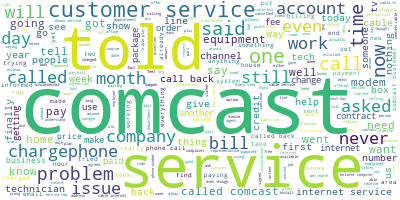

In [8]:
# Join the different processed titles together.
long_string = ','.join(list(data['text'] .values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [9]:
fcc_df['Customer Complaint'].value_counts() #to get the topics most complaints are based on

Comcast                                                                83
Comcast Internet                                                       18
Comcast Data Cap                                                       17
comcast                                                                13
Comcast Data Caps                                                      11
                                                                       ..
Comcast repeatedly failing to install Internet service                  1
Data Usage Overage                                                      1
Comcast bill problems                                                   1
Comcast-Non existent customer service, terrible internet connection     1
complaint about comcast                                                 1
Name: Customer Complaint, Length: 1842, dtype: int64

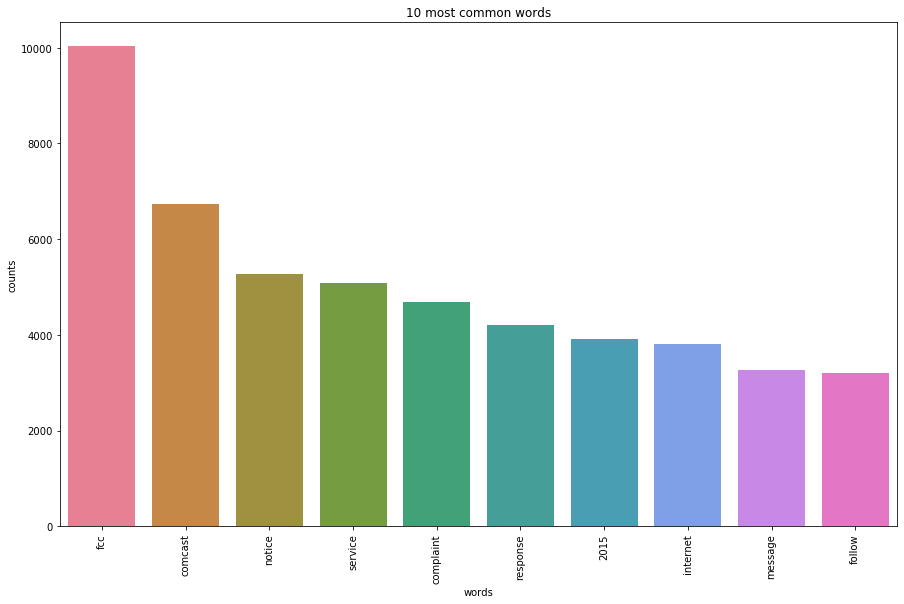

In [13]:
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(fcc_df['Description'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [14]:
def get_simple_topic_percentage(topic):
    """
    Returns a percentage of rows that this particular topic is found
    in using simple string manipulation. Note: this can have overlaps,
    for example if you have two topics, one 'Internet' and one 'Speed',
    you will get duplicate findings if the customer has 'Internet Speed'
    as their topic.
    
    topic: the customer complaint category entered by the customer.
    """
    return data[data['text'].str.contains(topic, case=False)].shape[0] / len(data['text']) * 100
    

print('Comcast:', get_simple_topic_percentage('comcast'))
print('Data cap:', get_simple_topic_percentage('data'))
print('Speed:', get_simple_topic_percentage('speed'))
print('Internet:', get_simple_topic_percentage('internet'))
print('Price:', get_simple_topic_percentage('price'))
print('Bill:', get_simple_topic_percentage('bill'))
print('Customer Service:', get_simple_topic_percentage('customer service'))

Comcast: 82.50133238585894
Data cap: 1.7942796233789304
Speed: 10.268253686267544
Internet: 44.892520874045125
Price: 11.440753242138923
Bill: 41.9790371291526
Customer Service: 30.627109610943332


In [16]:
nlp = English()

customize_stop_words = ['comcast', 'i', 'fcc', 'hello', 'service', 'services', 'issue',
                        'issues', 'problem', 'problems', 'xfinity', 'customer', 'complaint', '$']
for w in customize_stop_words:
    nlp.vocab[w].is_stop = True

def preprocess(verbatim):
    """
    Tokenizes, removes stopwords, and lemmatizes a verbatim text
    
    verbatim: a free-form text complaint
    """
    # Every verbatim ends with the FCC follow up, let's remove this.
    verbatim = verbatim.split('\n')[0].lower()
    doc = nlp(verbatim)
    sent = []
    for word in doc:
        # If it's not a stop word or punctuation mark, add it to our article!
        if word.text != 'n' and not word.is_stop and not word.is_punct and not word.like_num:
            # We add the lematized version of the word
            sent.append(word.lemma_.lower())
    return sent

# Tokenize each complaint
docs = fcc_df['Description'].apply(lambda verbatim: preprocess(verbatim))

In [17]:
docs[0]   #main complaints

['contacting',
 'internet',
 'technical',
 'support',
 'months',
 'resolve',
 'slow',
 'internet',
 'speed',
 'permanent',
 'resolution',
 'sent',
 'techs',
 'residence',
 'replaced',
 'hardware']

In [42]:
#from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer=TfidfVectorizer()
response=vectorizer.fit_transform(fcc_df['Customer Complaint'])

In [43]:
pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names())

,0057,10,100,1000ms,105,11,12,130,15,16mbps,...,xfintity,yahoo,year,years,yet,you,your,youtube,ypsilanti,yr
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [50]:
#from sklearn.decomposition import LatentDirichletAllocation
lda=LatentDirichletAllocation(n_components=5)
lda_com=lda.fit_transform(response)

In [51]:
#top 10 words  within each specific topic model
sorting=np.argsort(lda.components_)[:,: :-1]
features=np.array(vectorizer.get_feature_names())

In [52]:
#import mglearn
mglearn.tools.print_topics(topics=range(5),feature_names=features,sorting=sorting,topics_per_chunk=5,n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
no            caps          comcast       customer      billing       
internet      comcast       internet      service       issues        
service       xfinity       data          pricing       comcast       
comcast       speeds        cap           poor          practices     
problems      data          service       comcast       service       
to            internet      speed         and           unfair        
availability  connection    complaint     to            for           
against       deceptive     charges       from          internet      
my            terrible      cable         switch        and           
fees          hbo           usage         bait          slow          




In [53]:
top_labels = {0:'Complaints' , 1:'Comcast', 2:'Data Caps', 3:'Customer Service',4:'Billing'}# from the fcc csv